In [1]:
import numpy as np
import pandas as pd
import itertools
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from scipy.stats.mstats import zscore
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from tqdm import tqdm

# Load data

In [3]:
def bootstrapped(data,n_resamples = 5):
    data = (data,)
    bootstrap_ci = scipy.stats.bootstrap(data, np.mean, confidence_level=0.95,n_resamples=n_resamples,
                         random_state=1, method='percentile')
    return np.abs(bootstrap_ci.confidence_interval[1] - np.mean(data))

In [4]:
def set_fig_(ax , xlabel=0, ylabel=0 , xlog=0, ylog=0, fontsize=16, iflegend=0 , ncol=1, legendloc=2):
    if xlabel!=0:
        ax.set_xlabel(xlabel,size = fontsize)
    else:
        ax.set_xlabel('')
    if ylabel!=0:
        ax.set_ylabel(ylabel,size = fontsize)
    else:
        ax.set_ylabel('')
    if ylog:
        ax.set_yscale("log")
    if xlog:
        ax.set_xscale("log")
    if iflegend==1:
        ax.legend(frameon =False,fontsize = 14, loc=legendloc)
    if iflegend==2:
        ax.legend(frameon =False,fontsize = fontsize,ncol=ncol,bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)

In [5]:
df = pd.read_csv(r"E:\Data\Patent\KPSS\TextInnovation.csv.zip")
df['KI5'] = np.log(df['fsim5']/df['bsim5'])
for col in ['bsim5', 'fsim1', 'fsim5','fsim10', 'np_b5', 'np_f1', 'np_f5', 'np_f10']:
    del df[col]
df = df[df['filed_year'].isin(range(1980,2018))].reset_index(drop=True)

cd = pd.read_csv(r"E:\Data\Patent\KPSS\citations\Disruption.csv.zip")
cd['CD5'] = (cd['D5']-cd['C5'])/(cd['D5']+cd['C5']+cd['R5'])
df['CD5'] = df['patent_id'].map(cd.set_index('patent_id')['CD5'])

In [6]:
CPC = pd.read_csv(r"E:\Data\Patent\Patent\Field\cpc.csv.zip")
CPC1 = CPC[['patent_id','cpc_section']].drop_duplicates().reset_index(drop=True)
df1 = df.merge(CPC1,on='patent_id',how='left')

# Trend over time

In [7]:
avg_CD5 = df1.groupby(['filed_year' , 'cpc_section'])['CD5'].mean().reset_index()
avg_KI5 = df1.groupby(['filed_year' , 'cpc_section'])['KI5'].mean().reset_index()
N_P = df1.groupby(['filed_year' , 'cpc_section'])['patent_id'].count().reset_index()

avg_CD5['KI5'] = avg_KI5['KI5']
avg_CD5['n_p'] = N_P['patent_id']
avg_CD5['color'] = avg_CD5['cpc_section'].map(dict(zip(['A', 'B', 'F', 'Y', 'C', 'G', 'E', 'H', 'D'],sns.color_palette()[:9])))

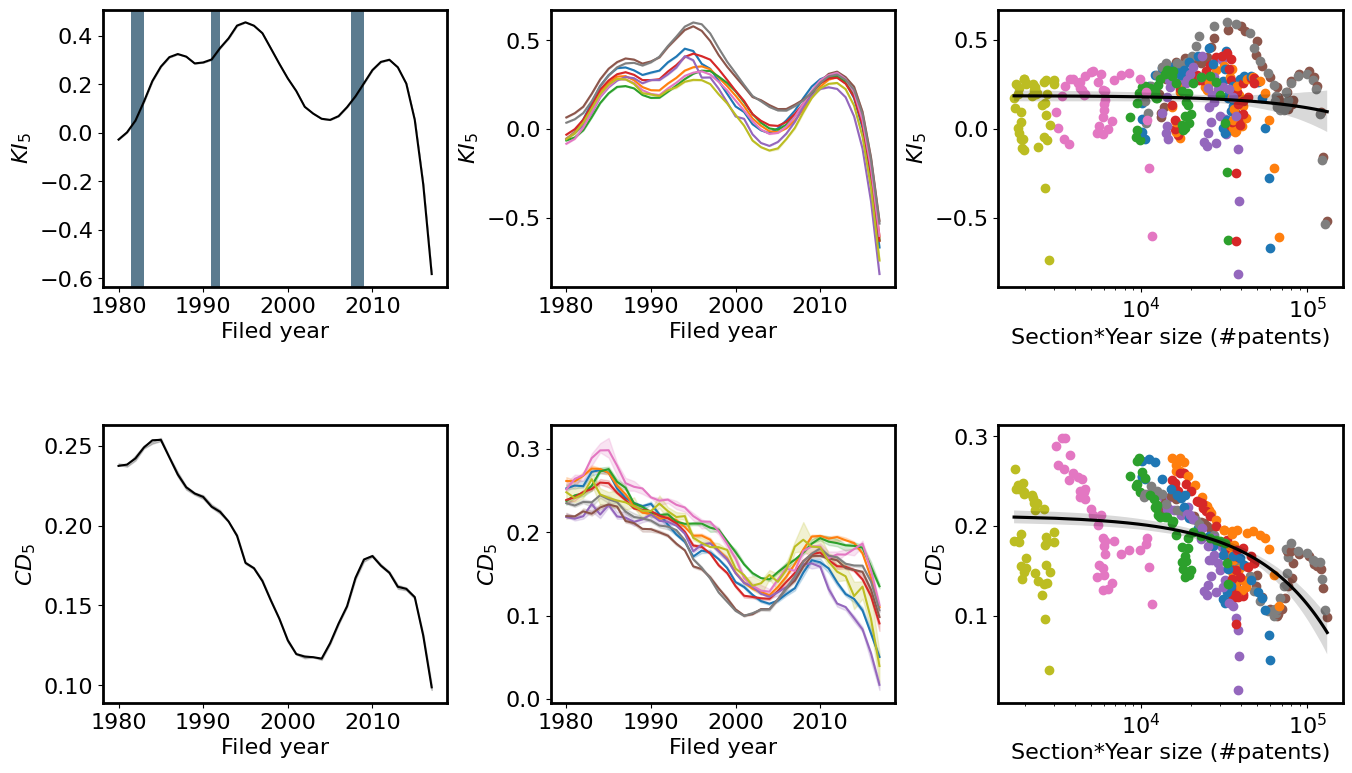

In [11]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 3, figure=fig)
gs.update(wspace=0.3,hspace=0.5)

ax = fig.add_subplot(gs[0])
sns.lineplot(df,  x='filed_year' ,y='KI5',color='k' , ls = '-', n_boot=5)
ax.axvspan(1981.5,1983, facecolor='#154360', alpha=0.7)
ax.axvspan(1990.9,1992, facecolor='#154360', alpha=0.7)
ax.axvspan(2007.5,2009, facecolor='#154360', alpha=0.7)
# ax.axvspan(2001.5,2002, facecolor='#154360', alpha=0.7)
set_fig_(ax , 'Filed year', '$KI_5$', 0, 0, iflegend=0)

ax = fig.add_subplot(gs[1])
sns.lineplot(df1,  x='filed_year' ,y='KI5' , hue='cpc_section', hue_order = ['A', 'B', 'F', 'Y', 'C', 'G', 'E', 'H', 'D'] , n_boot=5 , legend=0)
set_fig_(ax , 'Filed year', '$KI_5$', 0, 0, iflegend=0)

ax = fig.add_subplot(gs[2])
for i in range(len(avg_CD5)):
    plt.scatter(avg_CD5['n_p'].values[i] , avg_CD5['KI5'].values[i] , color =avg_CD5['color'].values[i])
sns.regplot(avg_CD5 , x='n_p' , y='KI5' , color='k' , scatter=0)
set_fig_(ax , 'Section*Year size (#patents)', '$KI_5$', 1, 0, iflegend=0)

ax = fig.add_subplot(gs[3])
sns.lineplot(df,  x='filed_year' ,y='CD5',color='k' , n_boot=5)
set_fig_(ax , 'Filed year', '$CD_5$', 0, 0, iflegend=0)

ax = fig.add_subplot(gs[4])
sns.lineplot(df1,  x='filed_year' ,y='CD5' , hue='cpc_section', hue_order = ['A', 'B', 'F', 'Y', 'C', 'G', 'E', 'H', 'D'] , n_boot=5 , legend=0)
set_fig_(ax , 'Filed year', '$CD_5$', 0, 0, iflegend=0)

ax = fig.add_subplot(gs[5])
for i in range(len(avg_CD5)):
    plt.scatter(avg_CD5['n_p'].values[i] , avg_CD5['CD5'].values[i] , color =avg_CD5['color'].values[i])
sns.regplot(avg_CD5 , x='n_p' , y='CD5' , color='k' , scatter=0)
set_fig_(ax , 'Section*Year size (#patents)', '$CD_5$', 1, 0, iflegend=0)

plt.savefig(savepath + "Trend.svg",bbox_inches = 'tight')

# Sub figs

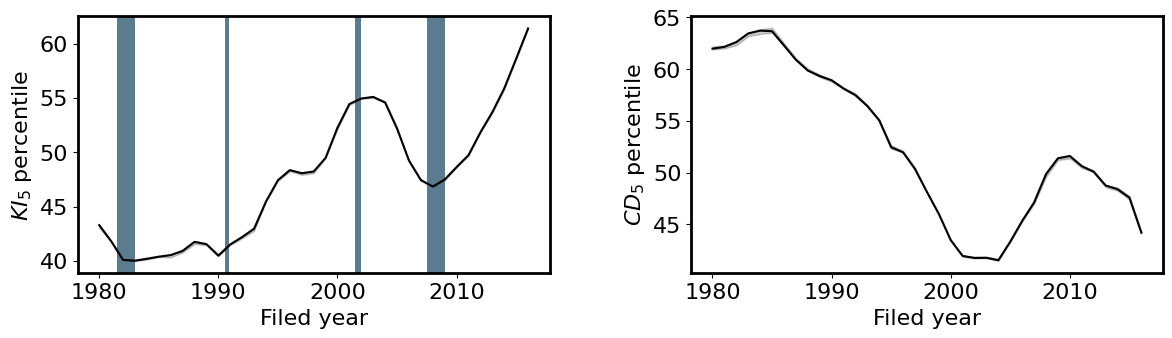

In [11]:
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2, 2, figure=fig)
gs.update(wspace=0.3,hspace=0.4)

ax = fig.add_subplot(gs[0])
sns.lineplot(df,  x='filed_year' ,y='KI5',color='k' , ls = '-', n_boot=5)
ax.axvspan(1981.5,1983, facecolor='#154360', alpha=0.7)
ax.axvspan(1990.6,1990.9, facecolor='#154360', alpha=0.7)
ax.axvspan(2007.5,2009, facecolor='#154360', alpha=0.7)
ax.axvspan(2001.5,2002, facecolor='#154360', alpha=0.7)
set_fig_(ax , 'Filed year', '$KI_5$', 0, 0, iflegend=0)

ax = fig.add_subplot(gs[1])
sns.lineplot(df,  x='filed_year' ,y='CD5',color='k' , n_boot=5)
set_fig_(ax , 'Filed year', '$CD_5$', 0, 0, iflegend=0)
plt.savefig(savepath + "Trend.svg",bbox_inches = 'tight')

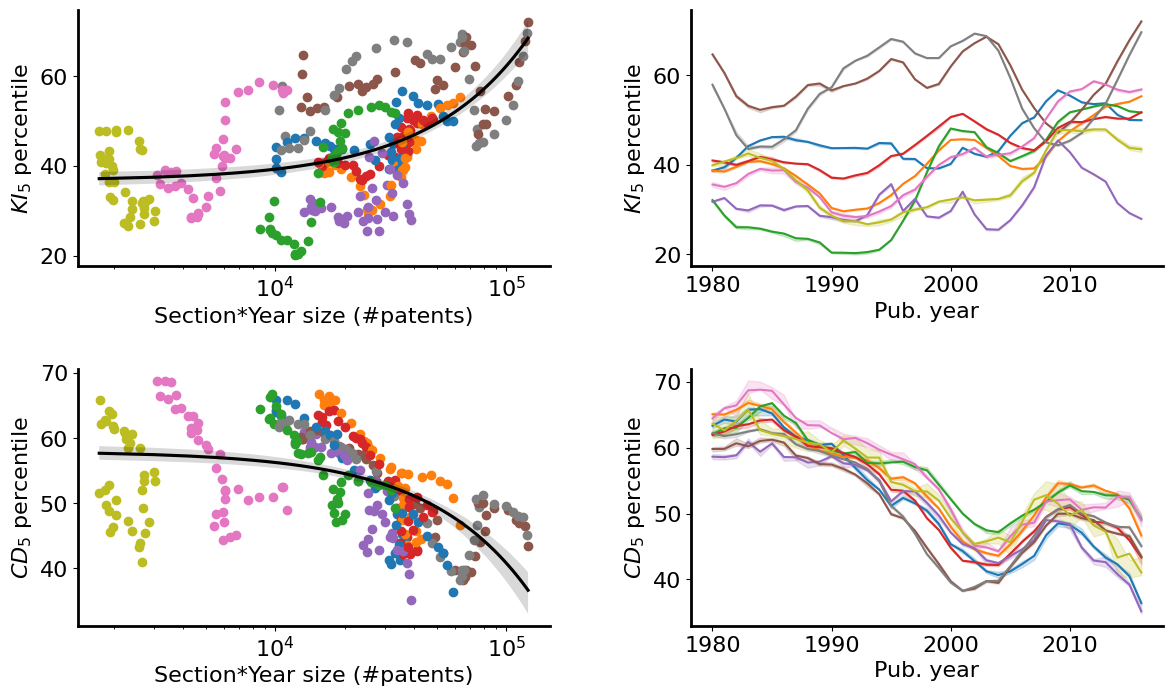

In [10]:
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2, 2, figure=fig)
gs.update(wspace=0.3,hspace=0.4)

ax = fig.add_subplot(gs[0])
for i in range(len(avg_CD5)):
    plt.scatter(avg_CD5['n_p'].values[i] , avg_CD5['KI5'].values[i] , color =avg_CD5['color'].values[i])
sns.regplot(avg_CD5 , x='n_p' , y='KI5' , color='k' , scatter=0)
set_fig_(ax , 'Section*Year size (#patents)', '$KI_5$', 1, 0, iflegend=0)

ax = fig.add_subplot(gs[1])
sns.lineplot(df1,  x='filed_year' ,y='KI5' , hue='cpc_section', hue_order = ['A', 'B', 'F', 'Y', 'C', 'G', 'E', 'H', 'D'] , n_boot=5 , legend=0)
set_fig_(ax , 'Pub. year', '$KI_5$', 0, 0, iflegend=0)

ax = fig.add_subplot(gs[2])
for i in range(len(avg_CD5)):
    plt.scatter(avg_CD5['n_p'].values[i] , avg_CD5['CD5'].values[i] , color =avg_CD5['color'].values[i])
sns.regplot(avg_CD5 , x='n_p' , y='CD5' , color='k' , scatter=0)
set_fig_(ax , 'Section*Year size (#patents)', '$CD_5$', 1, 0, iflegend=0)

ax = fig.add_subplot(gs[3])
sns.lineplot(df1,  x='filed_year' ,y='CD5' , hue='cpc_section', hue_order = ['A', 'B', 'F', 'Y', 'C', 'G', 'E', 'H', 'D'] , n_boot=5 , legend=0)
set_fig_(ax , 'Pub. year', '$CD_5$', 0, 0, iflegend=0)

plt.savefig(savepath + "Trend1.svg",bbox_inches = 'tight')

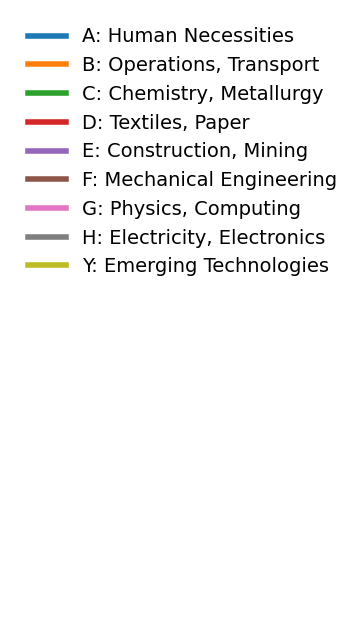

In [11]:
labellst = ['A: Human Necessities','B: Operations, Transport','C: Chemistry, Metallurgy','D: Textiles, Paper','E: Construction, Mining','F: Mechanical Engineering','G: Physics, Computing','H: Electricity, Electronics','Y: Emerging Technologies']

fig = plt.figure(figsize=(4,8))
gs = gridspec.GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0])
for i in range(9):
    plt.plot(1,1,color = sns.color_palette()[i] , label = labellst[i] , lw=4)
plt.yticks([])
plt.xticks([])
set_fig_(ax , iflegend=1)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.savefig(savepath + "Trend2_legend.svg",bbox_inches = 'tight')